# NYC 311
311 is a service that New York City residents can use to make non-emergency reports to the city for things like noise complaints, graffiti, potholes, etc. Each complaint that comes into the city is registered, along with additional information like the location, the neighborhood, the agency that responded to the request, etc.

## About the data
There are 40+ columns with over 21,000,000 rows approximately 12 GB in size.

The data has the following columns:
- `unique_key`: Unique identifier of a Service Request (SR) in the open data set
- `created_date`: Date SR was created
- `closed_date`: Date SR was closed
- `agency`: Acronym of responding City Government Agency
- `agency_name`: Full Agency name of responding City Government Agency
- `complaint_type`: This is the first level of a hierarchy identifying the topic of the incident or condition. Complaint Type may have a corresponding Descriptor (below) or may stand alone.
- `descriptor`: This is associated to the Complaint Type, and provides further detail on the incident or condition. Descriptor values are dependent on the Complaint Type, and are not always required in SR.
- `location_type`: Describes the type of location used in the address information
- `incident_zip`: Incident location zip code, provided by geo validation.
- `incident_address`: House number of incident address provided by submitter.
- `street_name`: Street name of incident address provided by the submitter
- `cross_street_1`: First Cross street based on the geo validated incident location
- `cross_street_2`: Second Cross Street based on the geo validated incident location
- `intersection_street_1`: First intersecting street based on geo validated incident location
- `intersection_street_2`: Second intersecting street based on geo validated incident location
- `address_type`: Type of incident location information available.
- `city`: City of the incident location provided by geovalidation.
- `landmark`: If the incident location is identified as a Landmark the name of the landmark will display here
- `facility_type`: If available, this field describes the type of city facility associated to the SR
- `status`: Status of SR submitted
- `due_date`: Date when responding agency is expected to update the SR. This is based on the Complaint Type and internal Service Level Agreements (SLAs).
- `resolution_description`: Describes the last action taken on the SR by the responding agency. May describe next or future steps.
- `resolution_action_updated_date`: Date when responding agency last updated the SR.
- `community_board`: Provided by geovalidation.
- `bbl`: Borough Block and Lot, provided by geovalidation. Parcel number to identify the location of location of buildings and properties in NYC.
- `borough`: Provided by the submitter and confirmed by geovalidation.
- `x_coordinate_state_plane`: Geo validated, X coordinate of the incident location.
- `y_coordinate_state_plane`: Geo validated, Y coordinate of the incident location.
- `open_data_channel_type`: Indicates how the SR was submitted to 311. i.e. By Phone, Online, Mobile, Other or Unknown.
- `park_facility_name`: If the incident location is a Parks Dept facility, the Name of the facility will appear here
- `park_borough`: The borough of incident if it is a Parks Dept facility
- `vehicle_type`: If the incident is a taxi, this field describes the type of TLC vehicle.
- `taxi_company_borough`: If the incident is identified as a taxi, this field will display the borough of the taxi company.
- `taxi_pick_up_location`: If the incident is identified as a taxi, this field displays the taxi pick up location
- `bridge_highway_name`: If the incident is identified as a Bridge/Highway, the name will be displayed here.
- `bridge_highway_direction`: If the incident is identified as a Bridge/Highway, the direction where the issue took place would be displayed here.
- `road_ramp`: If the incident location was Bridge/Highway this column differentiates if the issue was on the Road or the Ramp.
- `bridge_highway_segment`: Additional information on the section of the Bridge/Highway were the incident took place.
- `latitude`: Geo based Lat of the incident location
- `longitude`: Geo based Long of the incident location
- `location`: Combination of the geo based lat & long of the incident location

## Access
The data can be accessed either through a Redshift database or by [downloading the CSV](https://nycopendata.socrata.com/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9).

To access the Redshift database, make sure the associated `.env` file is in the same directory as this notebook. Using the `python-dotenv` module, the file sets environment variables which can be read into the notebook without displaying the password.

---

# Tasks

## Data Analysis
1. How many incidents were opened in each year beginning with 2010?
1. Which borough has the most incidents?

## Build a Data Product
Your task is to use your data science skills to identify a data story and build a data product from the New York City 311 Service Request data set.

1. First, we'd like you to create a model to predict what the type of a given complaint will be.
1. After that, we encourage you to add anything else you find exciting that showcases your skills
  - another predictive model
  - an interactive dashboard or visualization
  - an interesting statistical analysis
  - or anything else you dream up!
 
Be creative, but the most important thing is to showcase your data skills.

---

# Examine the data

In [1]:
import os

import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
import seaborn as sns; sns.set()
import spacy
import xgboost as xgb
from dotenv import load_dotenv
from joblib import dump, load
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, train_test_split

In [2]:
nlp = spacy.load('en_core_web_lg') # language model for NLP exploration
pd.set_option('display.max_columns', None) # set pandas to display all columns
RS = 0 # random state

## Load data using Redshift

In [3]:
# Get SQL connection info from .env file for interacting with Redshift
load_dotenv()
HOST = os.getenv('EZOIC_HOST')
PORT = os.getenv('EZOIC_PORT')
DB = os.getenv('EZOIC_DB')
USERNAME = os.getenv('EZOIC_USERNAME')
PASSWORD = os.getenv('EZOIC_PASSWORD')

In [4]:
def query_db(query):
    """
    Runs SQL query on NYC-311 Redshift database and returns a pandas DataFrame
    
    Redshift is a data warehouse based on PostgreSQL so syntax is mostly the same. 
    This function makes use of environment variables set through a .env file and
    loaded via the python-dotenv (or similar) module.
    
    Parameters:
    -----------
    query : str, SQL query
    
    Returns:
    --------
    df : pandas DataFrame, result of SQL query loaded into a DataFrame
    """
    conn = psycopg2.connect(host=HOST,
                            port=PORT,
                            dbname=DB,
                            user=USERNAME,
                            password=PASSWORD)
    cur = conn.cursor()
    cur.execute(query)
    rows = cur.fetchall()
    df = pd.DataFrame(rows)
    return df

In [5]:
# Example Redshift usage
print(query_db("SELECT count(1) FROM public.three_one_one;"))

          0
0  21351116


Since the data is too large to fit into memory, I can instead sample from the data set and work with a smaller, representative data set.

In [221]:
# Redshift does not seem to have the TABLESAMPLE command so instead order by random() to get a sample
#query = """SELECT * from public.three_one_one TABLESAMPLE SYSTEM((100 * 100) / 21000000) REPEATABLE 0;"""
query = """SELECT * from public.three_one_one ORDER BY random() LIMIT 100000;"""
df_sql = query_db(query)
df_sql.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
0,36359781,2017-06-05 01:04:38,2017-06-05 01:48:21,NYPD,New York City Police Department,Noise - Vehicle,Engine Idling,Street/Sidewalk,11206.0,7 BUSHWICK PLACE,BUSHWICK PLACE,MESEROLE STREET,MONTROSE AVENUE,,,ADDRESS,BROOKLYN,,Precinct,Closed,2017-06-05 09:04:38,The Police Department responded to the complai...,2017-06-05 01:48:21,01 BROOKLYN,3.030560e+09,BROOKLYN,1001232.0,197326.0,MOBILE,Unspecified,BROOKLYN,,,,,,,,40.708274747271840,-73.93874762434764,"(40.70827474727184, -73.93874762434764)"
1,32838569,2016-03-05 13:39:32,2016-03-05 14:38:51,NYPD,New York City Police Department,Blocked Driveway,Partial Access,Street/Sidewalk,11361.0,45-38 218 STREET,218 STREET,NORTHERN BOULEVARD,46 AVENUE,,,ADDRESS,BAYSIDE,,Precinct,Closed,2016-03-05 21:39:32,The Police Department responded and upon arriv...,2016-03-05 14:38:51,11 QUEENS,4.073370e+09,QUEENS,1049727.0,216376.0,ONLINE,Unspecified,QUEENS,,,,,,,,40.760336144084060,-73.76364614742785,"(40.76033614408406, -73.76364614742785)"
2,34708523,2016-11-04 12:19:02,2016-11-17 18:26:29,DOF,Refunds and Adjustments,DOF Property - Payment Issue,Incorrect Amount Paid,Property Address,11411.0,,,,,,,ADDRESS,CAMBRIA HEIGHTS,,N/A,Closed,2016-11-25 12:19:02,The Department of Finance was unable to resolv...,2016-11-17 18:26:29,13 QUEENS,4.128170e+09,QUEENS,NaN,NaN,PHONE,Unspecified,QUEENS,,,,,,,,None,None,
3,40609212,2018-10-20 13:13:57,2018-10-25 20:21:10,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,11225.0,1614 BEDFORD AVENUE,BEDFORD AVENUE,,,,,ADDRESS,BROOKLYN,,N/A,Closed,NaT,The complaint you filed is a duplicate of a co...,2018-10-25 20:21:10,09 BROOKLYN,3.012800e+09,BROOKLYN,996410.0,182528.0,PHONE,Unspecified,BROOKLYN,,,,,,,,40.667665580123120,-73.95616680114807,"(40.66766558012312, -73.95616680114807)"
4,31469401,2015-09-04 12:38:10,2015-09-30 16:27:24,HPD,Department of Housing Preservation and Develop...,DOOR/WINDOW,WINDOW FRAME,RESIDENTIAL BUILDING,10023.0,164 WEST 75 STREET,WEST 75 STREET,,,,,ADDRESS,NEW YORK,,N/A,Closed,NaT,The Department of Housing Preservation and Dev...,2015-09-30 16:27:24,07 MANHATTAN,1.011460e+09,MANHATTAN,990039.0,223483.0,ONLINE,Unspecified,MANHATTAN,,,,,,,,40.780083567934305,-73.97909713973222,"(40.780083567934305, -73.97909713973222)"


## Load data from local CSV

To work without an internet connection, it is useful to use a local copy of the data. Due to the size of the data set, working with all of the data is difficult on a regular laptop. In order to explore the data and build the analysis pipeline, I decided to sample the data and create a smaller CSV file.

One method I tried involves using the shell command `shuf` which shuffles the lines of a file. By providing a number argument, the command will output that many shuffled lines which can be stored in a new CSV. The problem with this method is that it shuffles all of the rows before displaying the desired amount. A benefit to this method is that the output will have the exact number of rows specified.

In [ ]:
# Use `shuf` to randomly shuffle and sample using Git for Windows
!C:\"Program Files"\Git\usr\bin\shuf -n 100000 311_Service_Requests_from_2010_to_Present.csv > sample.csv

# Add header line to sampled dataset
!sed -i 1i"`head -n 1 311_Service_Requests_from_2010_to_Present.csv`" sample.csv

Another method uses another set of shell commands, `tail` and `awk`. Each line is associated with a random number between 0 and 1 and if it is less than the threshold, the line is saved into a file. This is a probablistic method so the exact number of rows saved will only be approximate, however, this was a much quicker method for generating a sampled data set.

In [ ]:
# Use tail and awk to randomly sample using Git for Windows
!C:\"Program Files"\Git\usr\bin\tail --lines=+2 311_Service_Requests_from_2010_to_Present.csv | \
    C:\"Program Files"\Git\usr\bin\awk 'BEGIN {srand()} !/^$/ { if (rand() <= .01) print $0}'> sample.csv

# Add header line to sampled dataset
!sed -i 1i"`head -n 1 311_Service_Requests_from_2010_to_Present.csv`" sample-awk.csv

In [5]:
# check to see how many lines were sampled
!C:\"Program Files"\Git\usr\bin\wc -l sample-awk.csv

218397 sample-awk.csv


## Explore the sampled data set

In [6]:
# skip location column as it's the same as latitude and longitude
# use 200,000 rows for convenience when looking at how many non-nulls exist per column
date_cols = ['Created Date', 'Closed Date', 'Due Date', 'Resolution Action Updated Date']
df_samp = pd.read_csv('sample-awk.csv', low_memory=False, index_col=False, parse_dates=date_cols, usecols=[x for x in range(40)], nrows=200000)

In [7]:
# For convenience, make columns lowercase with underscores instead of spaces
df_samp.columns = df_samp.columns.str.lower()
df_samp.columns = df_samp.columns.str.replace(' ', '_')

In [8]:
# Look at the first few rows to get an idea about the data
df_samp.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,cross_street_2,intersection_street_1,intersection_street_2,address_type,city,landmark,facility_type,status,due_date,resolution_description,resolution_action_updated_date,community_board,bbl,borough,x_coordinate_(state_plane),y_coordinate_(state_plane),open_data_channel_type,park_facility_name,park_borough,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude
0,41781702,2018-05-10 12:06:07,2018-06-11 00:00:00,DOB,Department of Buildings,Elevator,Elevator - Multiple Devices On Property,NaN,11235,2 WEST END AVENUE,WEST END AVENUE,NaN,NaN,NaN,NaN,ADDRESS,BROOKLYN,NaN,NaN,Closed,NaT,The Department of Buildings investigated this ...,2018-06-11,15 BROOKLYN,3.087138e+09,BROOKLYN,997083.0,151183.0,UNKNOWN,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.581629,-73.953800
1,41781769,2018-12-22 11:05:02,2019-02-08 00:00:00,DOB,Department of Buildings,Elevator,Elevator - Single Device On Property/No Altern...,NaN,10001,165 WEST 26 STREET,WEST 26 STREET,NaN,NaN,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,NaT,The Department of Buildings investigated this ...,2019-02-08,05 MANHATTAN,1.008020e+09,MANHATTAN,986147.0,210899.0,UNKNOWN,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.745545,-73.993154
2,41781798,2018-12-05 08:19:00,2018-12-05 08:19:00,DOB,Department of Buildings,Elevator,Elevator - Single Device On Property/No Altern...,NaN,10025,401 WEST 110 STREET,WEST 110 STREET,NaN,NaN,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,NaT,The Department of Buildings investigated this ...,2018-12-05,09 MANHATTAN,1.018650e+09,MANHATTAN,994912.0,231464.0,UNKNOWN,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.801985,-73.961489
3,41781914,2018-09-17 13:31:27,2018-09-17 13:31:27,DOB,Department of Buildings,Elevator,Elevator - Single Device On Property/No Altern...,NaN,10282,345 CHAMBERS STREET,CHAMBERS STREET,NaN,NaN,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,NaT,The Department of Buildings investigated this ...,2018-09-17,01 MANHATTAN,1.000160e+09,MANHATTAN,980372.0,200754.0,UNKNOWN,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.717699,-74.013990
4,41782006,2018-06-22 14:06:38,2018-06-29 00:00:00,DOB,Department of Buildings,Elevator,Elevator - Single Device On Property/No Altern...,NaN,10032,251 FORT WASHINGTON AVENUE,FORT WASHINGTON AVENUE,NaN,NaN,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,NaT,The Department of Buildings determined that th...,2018-06-29,12 MANHATTAN,1.021390e+09,MANHATTAN,1000430.0,246627.0,UNKNOWN,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.843594,-73.941522


In [9]:
# Get summary information on non-numeric columns
df_samp.describe(include=np.object)

,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,cross_street_2,intersection_street_1,intersection_street_2,address_type,city,landmark,facility_type,status,resolution_description,community_board,borough,open_data_channel_type,park_facility_name,park_borough,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment
count,200000,200000,200000,197733,149209,187104,160067,160053,135174,134400,35750,35673,186708,186672,4644,48345,200000,196220,200000,200000,200000,199996,200000,81,159,1571,520,533,528,583
unique,24,222,250,1104,132,312,105228,9066,10476,10739,6386,6705,5,179,1921,4,8,967,77,6,5,711,6,4,10,264,42,42,2,386
top,HPD,Department of Housing Preservation and Develop...,Noise - Residential,Loud Music/Party,RESIDENTIAL BUILDING,11226,34 ARDEN STREET,BROADWAY,BEND,BEND,BROADWAY,BROADWAY,ADDRESS,BROOKLYN,BROADWAY,Precinct,Closed,The Department of Housing Preservation and Dev...,0 Unspecified,BROOKLYN,PHONE,Unspecified,BROOKLYN,Car Service,BROOKLYN,Other,BQE/Gowanus Expwy,East/Long Island Bound,Roadway,Ramp
freq,54961,54957,16043,16044,54326,3370,142,1865,2398,2434,616,574,150381,59573,76,41837,190255,15785,12308,58927,102855,198639,58927,67,45,931,62,55,380,23


### Initial summary of the data

There are 250 unique complaint types in the sample which means there could be more in the full data set. It would be best to try to reduce the cardinality by grouping similar complaints into broader categories. It might be easy to group them based on their values, or it might require keeping the top X values and setting the remaining values to an 'others' category. A more involved method would be to make use of natural language processing and generate average word vectors for each complaint and group complaints based on these vectors.

Additionally, some other features have high cardinality that will need to be addressed. These will also need to be transformed into numeric values for modeling while keeping the total dimensionality relatively small. One-hot encoding would not be a good choice for the high cardinality features. Some possible methods to explore are Weight of Evidence, Supervised Ratios, and binary encoding.

As expected, there are some null values. Based on the type of complaint, it makes sense that some columns would have null values. These will likely need to be addressed for analyses.

---

# Data Analysis

## Task 1

How many incidents are there each year starting with 2010?

In [10]:
# Use the creation date to extract the year
# Count how many rows are associated with each year
df_samp.loc[:, 'year'] = df_samp.created_date.apply(lambda x: x.year)
years = df_samp.year.value_counts().sort_index()
for year, count in zip(years.index, years):
    print(f'In {year}, there were {count} complaints')

In 2010, there were 20373 complaints
In 2011, there were 19507 complaints
In 2012, there were 17831 complaints
In 2013, there were 18320 complaints
In 2014, there were 21205 complaints
In 2015, there were 22863 complaints
In 2016, there were 23812 complaints
In 2017, there were 25081 complaints
In 2018, there were 12863 complaints
In 2019, there were 18145 complaints


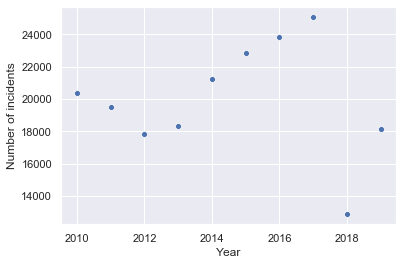

In [11]:
# Show the counts in a scatterplot for easier comparison between years
sns.scatterplot(years.index, years)
plt.xlabel('Year')
plt.ylabel('Number of incidents')
plt.show()

There's an interesting dip in complaints during 2018 though this could be an artifact from the sampling. If this is a true dip then I would suspect possible data entry problems which may or may not be recoverable.

## Task 2

Which borough had the most incidents? Total? Per year?

In [12]:
# Borough with the most incidents since 2010
incidents_vc = df_samp.borough.value_counts()
max_borough = incidents_vc.idxmax()
max_counts = incidents_vc[max_borough]
print(f'The borough with the most total incidents was {max_borough} with a total of {max_counts}')

The borough with the most total incidents was BROOKLYN with a total of 58927


In [13]:
# Borough with the most incidents per year starting with 2010
for year in sorted(years.index):
    vc = df_samp.loc[df_samp.year == year, 'borough'].value_counts()
    max_borough = vc.idxmax()
    max_counts = vc[max_borough]
    print(f'In {year}, the borough {max_borough} had the most complaints with {max_counts}.')

In 2010, the borough Unspecified had the most complaints with 7164.
In 2011, the borough BROOKLYN had the most complaints with 5627.
In 2012, the borough BROOKLYN had the most complaints with 5451.
In 2013, the borough BROOKLYN had the most complaints with 5736.
In 2014, the borough BROOKLYN had the most complaints with 6584.
In 2015, the borough BROOKLYN had the most complaints with 7019.
In 2016, the borough BROOKLYN had the most complaints with 7151.
In 2017, the borough BROOKLYN had the most complaints with 7865.
In 2018, the borough BROOKLYN had the most complaints with 4038.
In 2019, the borough BROOKLYN had the most complaints with 5678.


---

# Build a Data Product

## Predict the type of complaint

The initial models I will try are logistic regression, random forest classifer, and XGBoost classifier. Both logistic regression and random forest are standard for generating quick baseline models. XGBoost has become a popular algorithm in Kaggle competitions and is also a quick model to develop. 

There are a large number of unique complaint types. These will be reduced by grouping complaints into broader categories and then selection the ones that appear most frequently in the data set. The leftover types will be grouped into a single value called 'others'.

The categorical features will need to be converted into numeric values, and for logistic regression, the values will need to be standardized. For the high cardinality features, these will be converted using the Weight of Evidence transformation.

### Preprocessing

#### Reduce complaint type cardinality

In [14]:
# make complaints lowercase, replace / with space, and remove double spaces
print(f'Unique values before: {df_samp.complaint_type.unique().shape[0]}')
df_samp.loc[:, 'complaint_type'] = df_samp.complaint_type.apply(lambda x: x.lower())
df_samp.loc[:, 'complaint_type_new'] = df_samp.complaint_type.apply(lambda x: x.replace('/', ' '))
df_samp.loc[:, 'complaint_type_new'] = df_samp.complaint_type_new.apply(lambda x: x.replace(' -', ' '))
df_samp.loc[:, 'complaint_type_new'] = df_samp.complaint_type_new.apply(lambda x: x.replace('  ', ' '))
print(f'Unique values after: {df_samp.complaint_type.unique().shape[0]}')

Unique values before: 250
Unique values after: 244


In [15]:
# look at the complaint types to see how to generalize
vc = df_samp.complaint_type_new.value_counts()
vc[:25]

noise residential                16043
heat hot water                   10243
street condition                  9059
heating                           8911
street light condition            8660
blocked driveway                  8029
illegal parking                   7543
plumbing                          7168
paint plaster                     6571
water system                      5868
general construction              5077
general construction plumbing     4526
noise                             4325
traffic signal condition          4159
noise street sidewalk             4152
unsanitary condition              3946
sewer                             3265
dirty conditions                  3203
noise commercial                  3118
electric                          2899
damaged tree                      2731
nonconst                          2673
sanitation condition              2624
building use                      2569
rodent                            2452
Name: complaint_type_new,

Manually going through each complaint type and determining an appropriate generalization is cumbersome and prone to error or unexpected behavior once new data comes in. Instead, it would be better to try to combine some obvious complaints into one and then use the complaints that contribute to at least 1% of the data set. All others can be lumped into an 'others' category.

In [16]:
# create reduced complaint types
# generalize a few obvious similar complaint types
df_samp.loc[:, 'complaint_type_reduced'] = df_samp.loc[:, 'complaint_type_new']
df_samp.loc[df_samp.complaint_type_new.str.contains('noise'), 'complaint_type_reduced'] = 'noise'
df_samp.loc[df_samp.complaint_type_new.str.contains('tree'), 'complaint_type_reduced'] = 'tree'
df_samp.loc[df_samp.complaint_type_new.str.contains('vehicle'), 'complaint_type_reduced'] = 'vehicle'
df_samp.loc[df_samp.complaint_type_new.str.contains('taxi'), 'complaint_type_reduced'] = 'taxi'
df_samp.loc[df_samp.complaint_type_new.str.contains('sign'), 'complaint_type_reduced'] = 'sign'
df_samp.loc[df_samp.complaint_type_new.str.contains('animal'), 'complaint_type_reduced'] = 'animal'
df_samp.loc[df_samp.complaint_type_new.str.contains('heat'), 'complaint_type_reduced'] = 'heating'
df_samp.loc[df_samp.complaint_type_new.str.contains('plumbing'), 'complaint_type_reduced'] = 'plumbing'
df_samp.loc[df_samp.complaint_type_new.str.contains('parking'), 'complaint_type_reduced'] = 'parking'
df_samp.loc[df_samp.complaint_type_new == 'sanitation condition', 'complaint_type_reduced'] = 'sanitation'
df_samp.loc[df_samp.complaint_type_new == 'unsanitary condition', 'complaint_type_reduced'] = 'sanitation'
df_samp.loc[df_samp.complaint_type_new == 'indoor sewage', 'complaint_type_reduced'] = 'sanitation'
df_samp.loc[df_samp.complaint_type_new.str.contains('collection'), 'complaint_type_reduced'] = 'sanitation'

print(f'Number of unique complaints: {df_samp.complaint_type_reduced.unique().shape[0]}')

Number of unique complaints: 184


In [17]:
# determine percentage of complaints using reduced types
vc_reduced = (df_samp.complaint_type_reduced.value_counts() / df_samp.shape[0])
(idx,) = np.where(vc_reduced.cumsum() > 0.85)
print(f'Number of types to cover 85% of complaints: {vc_reduced[:idx[1]].shape[0]}')
print(f'Number of types with greater than 1% of complaints: {vc_reduced[vc_reduced > 0.01].shape[0]}')
vc_reduced[vc_reduced > 0.01]

Number of types to cover 85% of complaints: 25
Number of types with greater than 1% of complaints: 19


tree                    0.142045
noise                   0.120905
heating                 0.096285
plumbing                0.058470
sanitation              0.054230
parking                 0.045500
blocked driveway        0.040145
paint plaster           0.032855
vehicle                 0.031170
water system            0.029340
sign                    0.027805
general construction    0.025385
sewer                   0.016325
dirty conditions        0.016015
electric                0.014495
nonconst                0.013365
building use            0.012845
rodent                  0.012260
sidewalk condition      0.011305
Name: complaint_type_reduced, dtype: float64

In [18]:
# Combine the other complaint types into an 'other' value
types_to_keep = vc_reduced[vc_reduced > 0.01].index.tolist()
df_samp.loc[~df_samp.complaint_type_reduced.isin(types_to_keep), 'complaint_type_reduced'] = 'other'
print(df_samp.complaint_type_reduced.unique())

['other' 'plumbing' 'tree' 'vehicle' 'sign' 'heating' 'paint plaster'
 'blocked driveway' 'sanitation' 'parking' 'noise' 'water system'
 'sidewalk condition' 'electric' 'building use' 'rodent'
 'dirty conditions' 'sewer' 'general construction' 'nonconst']


By combining some complaints and only using the types that correspond to at least 1% of the data, I reduced the complaints down to 19 which contribute 80% of the data set. The remaining 20% of the data are combined into the 20th type called 'other'.

In [19]:
# label encode the reduced complaint types
unique_complaints = df_samp.complaint_type_reduced.unique().tolist()
le = preprocessing.LabelEncoder()
le.fit(unique_complaints)
print(le.classes_)

['blocked driveway' 'building use' 'dirty conditions' 'electric'
 'general construction' 'heating' 'noise' 'nonconst' 'other'
 'paint plaster' 'parking' 'plumbing' 'rodent' 'sanitation' 'sewer'
 'sidewalk condition' 'sign' 'tree' 'vehicle' 'water system']


In [20]:
df_samp.loc[:, 'complaint_encoded'] = le.transform(df_samp.loc[:, 'complaint_type_reduced'])
df_samp.loc[20:30, ['complaint_type_reduced', 'complaint_encoded']]

,complaint_type_reduced,complaint_encoded
20,other,8
21,sign,16
22,other,8
23,other,8
24,heating,5
25,heating,5
26,heating,5
27,heating,5
28,heating,5
29,paint plaster,9


#### Transform categorical data into numeric

For binary targets, I can use methods like Supervised Ratio or Weight of Evidence to transform high cardinality features into numbers. To expand into multi-class, I can repeat the process in a one-vs-rest fashion for each target class. Since I have 20 classes, I would change each categorical feature to 20 new features which is much smaller than one-hot encoding. This could be a useful method only for features that have cardinality higher than 20 otherwise using one-hot encoding would be better.

In [21]:
# Use the descibe method to see which features have high cardinality
df_samp.describe(include=np.object)

,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,cross_street_2,intersection_street_1,intersection_street_2,address_type,city,landmark,facility_type,status,resolution_description,community_board,borough,open_data_channel_type,park_facility_name,park_borough,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,complaint_type_new,complaint_type_reduced
count,200000,200000,200000,197733,149209,187104,160067,160053,135174,134400,35750,35673,186708,186672,4644,48345,200000,196220,200000,200000,200000,199996,200000,81,159,1571,520,533,528,583,200000,200000
unique,24,222,244,1104,132,312,105228,9066,10476,10739,6386,6705,5,179,1921,4,8,967,77,6,5,711,6,4,10,264,42,42,2,386,243,20
top,HPD,Department of Housing Preservation and Develop...,noise - residential,Loud Music/Party,RESIDENTIAL BUILDING,11226,34 ARDEN STREET,BROADWAY,BEND,BEND,BROADWAY,BROADWAY,ADDRESS,BROOKLYN,BROADWAY,Precinct,Closed,The Department of Housing Preservation and Dev...,0 Unspecified,BROOKLYN,PHONE,Unspecified,BROOKLYN,Car Service,BROOKLYN,Other,BQE/Gowanus Expwy,East/Long Island Bound,Roadway,Ramp,noise residential,other
freq,54961,54957,16043,16044,54326,3370,142,1865,2398,2434,616,574,150381,59573,76,41837,190255,15785,12308,58927,102855,198639,58927,67,45,931,62,55,380,23,16043,39851


The features I think would be useful for a baseline model are the following:
- created_year
- created_month
- created_day
- created_hour
- created_minute
- agency (transforms into 20 features)
- location type (transforms into 20 features)
- incident_zip (transforms into 20 features)
- has_landmark
- facility type (4 features after one-hot encoding) 
- borough (5 features after one-hot encoding) 
- has_vehicle_type
- address_type (5 features after one-hot encoding)

Total: 81 columns

In [22]:
# split date into parts (year, month, day, hour, minute)
df_samp.loc[:, 'month'] = df_samp.created_date.apply(lambda x: x.month)
df_samp.loc[:, 'day'] = df_samp.created_date.apply(lambda x: x.day)
df_samp.loc[:, 'hour'] = df_samp.created_date.apply(lambda x: x.hour)
df_samp.loc[:, 'minute'] = df_samp.created_date.apply(lambda x: x.minute)

# Monday is considered 0
df_samp.loc[:, 'day_of_week'] = df_samp.created_date.apply(lambda x: x.dayofweek)

# check to make sure things look good
df_samp.loc[:5, ['created_date','year', 'month', 'day', 'hour', 'minute']]

,created_date,year,month,day,hour,minute
0,2018-05-10 12:06:07,2018,5,10,12,6
1,2018-12-22 11:05:02,2018,12,22,11,5
2,2018-12-05 08:19:00,2018,12,5,8,19
3,2018-09-17 13:31:27,2018,9,17,13,31
4,2018-06-22 14:06:38,2018,6,22,14,6
5,2018-07-02 15:15:59,2018,7,2,15,15


In [23]:
def woe(df, col, y):
    """Calculates the Weight of Evidence (WOE)
    
    The WOE is defined as WOE_j = ln( (P_j/TP) / (N_j/TN) ), where j is the unique feature variable to be encoded,
    TP and TN are the true positive and true negative associated with the target class.
    
    Parameters:
    -----------
    df : pandas dataframe
    col : str, column name to encode
    y : str, target column name with classes label encoded
    """
    adjust_factor = 0.5 # to prevent NaN and infinities
    unique_vals = df[col].unique()
    for i in df[y].unique():
        TP = df[df[y] == i].shape[0]
        TN = df.shape[0] - TP
        for j in unique_vals:
            P_j = df[(df[y] == i) & (df[col] == j)].shape[0]
            N_j = df[df[col] == j].shape[0] - P_j
            woe = np.log(P_j + adjust_factor) - np.log(TP) - np.log(N_j + adjust_factor) + np.log(TN)
            df.loc[df[col] == j, f'{col}_{i}'] = woe
    return

In [24]:
features_to_encode = ['agency', 'location_type', 'incident_zip']
for feature in features_to_encode:
    # replace NaNs with 'Not specified' to prevent issue during WOE transformation
    df_samp[feature].fillna(value='Not specified', inplace=True)
    woe(df_samp, feature, 'complaint_encoded')
    df_samp.drop(feature, axis=1, inplace=True)
df_samp.head()

,unique_key,created_date,closed_date,agency_name,complaint_type,descriptor,incident_address,street_name,cross_street_1,cross_street_2,intersection_street_1,intersection_street_2,address_type,city,landmark,facility_type,status,due_date,resolution_description,resolution_action_updated_date,community_board,bbl,borough,x_coordinate_(state_plane),y_coordinate_(state_plane),open_data_channel_type,park_facility_name,park_borough,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,year,complaint_type_new,complaint_type_reduced,complaint_encoded,month,day,hour,minute,day_of_week,agency_8,agency_11,agency_17,agency_18,agency_16,agency_5,agency_9,agency_0,agency_13,agency_10,agency_6,agency_19,agency_15,agency_3,agency_1,agency_12,agency_2,agency_14,agency_4,agency_7,location_type_8,location_type_11,location_type_17,location_type_18,location_type_16,location_type_5,location_type_9,location_type_0,location_type_13,location_type_10,location_type_6,location_type_19,location_type_15,location_type_3,location_type_1,location_type_12,location_type_2,location_type_14,location_type_4,location_type_7,incident_zip_8,incident_zip_11,incident_zip_17,incident_zip_18,incident_zip_16,incident_zip_5,incident_zip_9,incident_zip_0,incident_zip_13,incident_zip_10,incident_zip_6,incident_zip_19,incident_zip_15,incident_zip_3,incident_zip_1,incident_zip_12,incident_zip_2,incident_zip_14,incident_zip_4,incident_zip_7
0,41781702,2018-05-10 12:06:07,2018-06-11 00:00:00,Department of Buildings,elevator,Elevator - Multiple Devices On Property,2 WEST END AVENUE,WEST END AVENUE,NaN,NaN,NaN,NaN,ADDRESS,BROOKLYN,NaN,NaN,Closed,NaT,The Department of Buildings investigated this ...,2018-06-11,15 BROOKLYN,3.087138e+09,BROOKLYN,997083.0,151183.0,UNKNOWN,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.581629,-73.953800,2018,elevator,other,8,5,10,12,6,3,0.615114,2.589031,-8.206417,-6.568192,-6.450484,-7.765623,-6.62258,-6.830541,-7.14606,-6.96135,-8.020937,-6.505801,-5.533684,-5.785475,3.145812,-5.615747,-5.88674,-5.906227,-6.356941,-5.703164,-0.08979,0.566427,0.893617,-2.268602,1.137438,-9.28943,-8.146387,-2.901022,-3.90655,-0.802498,-0.353237,1.463663,-7.057491,-7.309281,1.409758,-7.139554,-7.410547,1.420723,-7.880747,-7.226971,0.108495,-0.012807,-0.245355,0.136657,-0.143032,0.120424,-0.315128,0.433596,0.002415,0.164758,-0.306549,-0.128389,0.329739,-0.502312,0.271832,-0.153930,0.177518,0.618384,-0.002336,-0.089337
1,41781769,2018-12-22 11:05:02,2019-02-08 00:00:00,Department of Buildings,elevator,Elevator - Single Device On Property/No Altern...,165 WEST 26 STREET,WEST 26 STREET,NaN,NaN,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,NaT,The Department of Buildings investigated this ...,2019-02-08,05 MANHATTAN,1.008020e+09,MANHATTAN,986147.0,210899.0,UNKNOWN,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.745545,-73.993154,2018,elevator,other,8,12,22,11,5,5,0.615114,2.589031,-8.206417,-6.568192,-6.450484,-7.765623,-6.62258,-6.830541,-7.14606,-6.96135,-8.020937,-6.505801,-5.533684,-5.785475,3.145812,-5.615747,-5.88674,-5.906227,-6.356941,-5.703164,-0.08979,0.566427,0.893617,-2.268602,1.137438,-9.28943,-8.146387,-2.901022,-3.90655,-0.802498,-0.353237,1.463663,-7.057491,-7.309281,1.409758,-7.139554,-7.410547,1.420723,-7.880747,-7.226971,0.950052,-0.232874,-0.517298,-0.165042,-1.081530,-0.723224,-1.040033,-1.349219,-0.544185,-0.223458,0.558289,0.323909,0.624449,-1.647118,-0.934540,-0.685528,-0.517786,0.003679,-1.880978,-0.772945
2,41781798,2018-12-05 08:19:00,2018-12-05 08:19:00,Department of Buildings,elevator,Elevator - Single Device On Property/No Altern...,401 WEST 110 STREET,WEST 110 STREET,NaN,NaN,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,NaT,The Department of Buildings investigated this ...,2018-12-05,09 MANHATTAN,1.018650e+09,MANHATTAN,994912.0,231464.0,UNKNOWN,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.801985,-73.961489,2018,elevator,other,8,12,5,8,19,2,0.615

In [25]:
df_samp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 106 entries, unique_key to incident_zip_7
dtypes: datetime64[ns](4), float64(65), int32(1), int64(7), object(29)
memory usage: 161.0+ MB


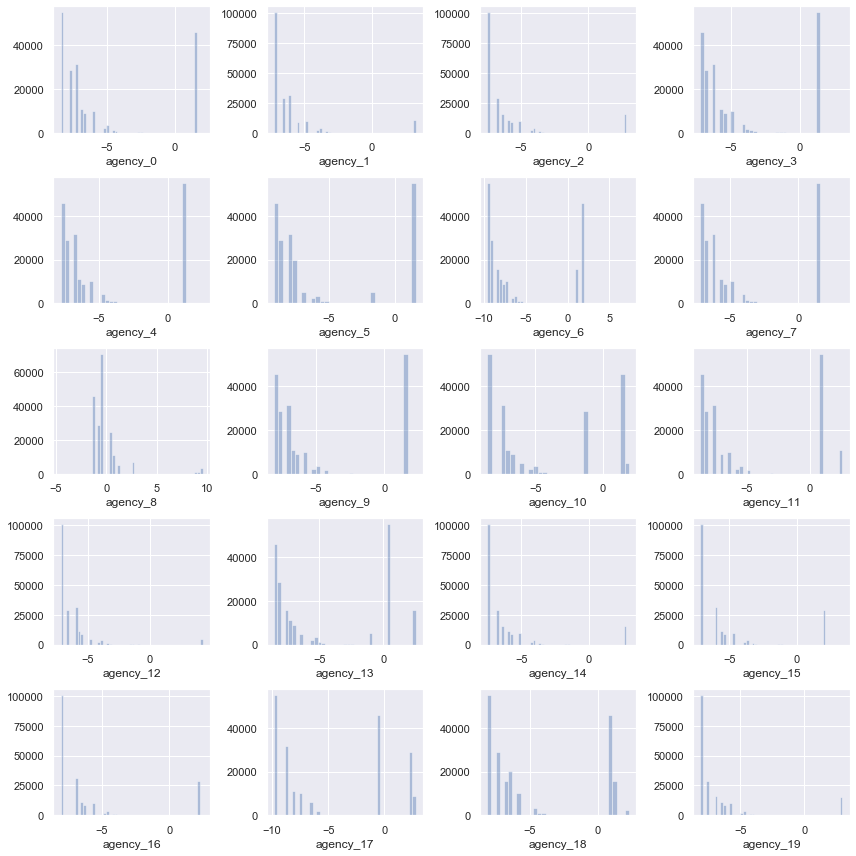

In [26]:
# examine distributions of new WOE features
row, col = 0, 0
feature = 'agency'
figs, axes = plt.subplots(nrows=5, ncols=4, figsize=(12,12))
for i in range(20):
    if col > 3:
        row += 1
        col = 0
    sns.distplot(df_samp[f'{feature}_{i}'], kde=False, ax=axes[row, col])
    col += 1
plt.tight_layout()

In [27]:
# Create booleans for has_landmark and has_vehicle_type
df_samp.loc[:, 'has_landmark'] = (df_samp.landmark.isna())
df_samp.has_landmark = df_samp.has_landmark.astype(int)

df_samp.loc[:, 'has_vehicle_type'] = (df_samp.vehicle_type.isna())
df_samp.has_vehicle_type = df_samp.has_vehicle_type.astype(int)

In [28]:
# Force values to be lower case
# Replace spaces with underscores
cols = ['borough', 'facility_type', 'address_type']
for col in cols:
    print(col)
    df_samp[col].fillna(value='Not specified', inplace=True) 
    df_samp.loc[:, col] = df_samp.loc[:, col].apply(lambda x: x.lower().replace(' ', '_'))
df_samp = pd.get_dummies(df_samp, prefix=cols, columns=cols, drop_first=True)

borough
facility_type
address_type


In [29]:
# drop unnecessary columns for modeling
to_drop = ['created_date', 'closed_date', 'agency_name', 'complaint_type',
           'descriptor', 'incident_address', 'street_name', 'cross_street_1',
           'cross_street_2', 'intersection_street_1', 'intersection_street_2',
           'city', 'landmark', 'status', 'due_date', 'resolution_description',
           'resolution_action_updated_date', 'community_board', 'bbl',
           'x_coordinate_(state_plane)', 'y_coordinate_(state_plane)',
           'open_data_channel_type', 'park_facility_name', 'park_borough',
           'vehicle_type', 'taxi_company_borough', 'taxi_pick_up_location',
           'bridge_highway_name', 'bridge_highway_direction', 'road_ramp',
           'bridge_highway_segment', 'latitude', 'longitude', 'complaint_type_new',
           'complaint_type_reduced']
df_model = df_samp.drop(to_drop, axis=1)

Note that 'descriptor' was dropped because it's related to the target variable. Including it in the feature matrix would lead to data leakage. 

In [30]:
df_model.shape

(200000, 84)

### Modeling

The models to be used for baselines are logistic regression, random forest, and XGBoost. Now that all features are numeric, the random forest and XGBoost models are ready. For logistic regression, the features need to be scaled prior to fitting.

In [31]:
# use unique_key as index
df_model = df_model.set_index('unique_key')
y = df_model.complaint_encoded
X = df_model.drop(['complaint_encoded'], axis=1)

In [32]:
X.head()

,year,month,day,hour,minute,day_of_week,agency_8,agency_11,agency_17,agency_18,agency_16,agency_5,agency_9,agency_0,agency_13,agency_10,agency_6,agency_19,agency_15,agency_3,agency_1,agency_12,agency_2,agency_14,agency_4,agency_7,location_type_8,location_type_11,location_type_17,location_type_18,location_type_16,location_type_5,location_type_9,location_type_0,location_type_13,location_type_10,location_type_6,location_type_19,location_type_15,location_type_3,location_type_1,location_type_12,location_type_2,location_type_14,location_type_4,location_type_7,incident_zip_8,incident_zip_11,incident_zip_17,incident_zip_18,incident_zip_16,incident_zip_5,incident_zip_9,incident_zip_0,incident_zip_13,incident_zip_10,incident_zip_6,incident_zip_19,incident_zip_15,incident_zip_3,incident_zip_1,incident_zip_12,incident_zip_2,incident_zip_14,incident_zip_4,incident_zip_7,has_landmark,has_vehicle_type,borough_brooklyn,borough_manhattan,borough_queens,borough_staten_island,borough_unspecified,facility_type_not_specified,facility_type_precinct,facility_type_school,facility_type_school_district,address_type_blockface,address_type_intersection,address_type_latlong,address_type_not_specified,address_type_placename
unique_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
41781702,2018,5,10,12,6,3,0.615114,2.589031,-8.206417,-6.568192,-6.450484,-7.765623,-6.62258,-6.830541,-7.14606,-6.96135,-8.020937,-6.505801,-5.533684,-5.785475,3.145812,-5.615747,-5.88674,-5.906227,-6.356941,-5.703164,-0.08979,0.566427,0.893617,-2.268602,1.137438,-9.28943,-8.146387,-2.901022,-3.90655,-0.802498,-0.353237,1.463663,-7.057491,-7.309281,1.409758,-7.139554,-7.410547,1.420723,-7.880747,-7.226971,0.108495,-0.012807,-0.245355,0.136657,-0.143032,0.120424,-0.315128,0.433596,0.002415,0.164758,-0.306549,-0.128389,0.329739,-0.502312,0.271832,-0.153930,0.177518,0.618384,-0.002336,-0.089337,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
41781769,2018,12,22,11,5,5,0.615114,2.589031,-8.206417,-6.568192,-6.450484,-7.765623,-6.62258,-6.830541,-7.14606,-6.96135,-8.020937,-6.505801,-5.533684,-5.785475,3.145812,-5.615747,-5.88674,-5.906227,-6.356941,-5.703164,-0.08979,0.566427,0.893617,-2.268602,1.137438,-9.28943,-8.146387,-2.901022,-3.90655,-0.802498,-0.353237,1.463663,-7.057491,-7.309281,1.409758,-7.139554,-7.410547,1.420723,-7.880747,-7.226971,0.950052,-0.232874,-0.517298,-0.165042,-1.081530,-0.723224,-1.040033,-1.349219,-0.544185,-0.223458,0.558289,0.323909,0.624449,-1.647118,-0.934540,-0.685528,-0.517786,0.003679,-1.880978,-0.772945,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
41781798,2018,12,5,8,19,2,0.615114,2.589031,-8.206417,-6.568192,-6.450484,-7.765623,-6.62258,-6.830541,-7.14606,-6.96135,-8.020937,-6.505801,-5.533684,-5.785475,3.145812,-5.615747,-5.88674,-5.906227,-6.356941,-5.703164,-0.08979,0.566427,0.893617,-2.268602,1.137438,-9.28943,-8.146387,-2.901022,-3.90655,-0.802498,-0.353237,1.463663,-7.057491,-7.309281,1.409758,-7.139554,-7.410547,1.420723,-7.880747,-7.226971,0.350456,-0.227373,-0.437707,-0.399007,-2.075567,0.414048,0.301014,-2.287916,-0.407805,-0.339403,0.461626,-0.014364,-0.116128,-0.304741,-0.976574,0.828366,0.074372,-1.219849,-0.097469,-0.002734,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
41781914,2018,9,17,13,31,0,0.615114,2.589031,-8.206417,-6.568192,-6.450484,-7.765623,-6.62258,-6.830541,-7.14606,-6.96135,-8.020937,-6.505801,-5.533684,-5.785475,3.145812,-5.615747,-5.88674,-5.906227,-6.356941,-5.703164,-0.08979,0.566427,0.893617,-2.268602,1.137438,-9.28943,-8.146387,-2.901022,-3.90655,-0.802498,-0.353237,1.463663,-7.057491,-7.309281,1.409758,-7.139554,-7.410547,1.420723,-7.880747,-7.226971,0.560609,-0.092687,-0.147502,-0.570700,-0.452993,0.293291,-0.625089,-0.833049,-1.148568,1.390552,0.978366,0.627345,0.463808,0.212017,0.334539,0.381744,0.110752,0.091265,-0.359449,0.294328,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
41782006,2018,6,22,14,6,4,0.615114,2.589031,-8.206417,-6.568192,-6.450484,-7.765623,-6.62258,-6.830541,-7.14606,-6.96135,-8.020937,-6.505801,-5.533684,-5.78

In order to validate the models and determine how well they'll work on unseen data, I'll need to split the data into train, validation, and test sets. The test set will be set aside immediately while the remainder of the data will go through a cross-validation procedure.

In [33]:
# create stratified split for k-fold validation
# train/val/test 60%/20%/20%
# create test set to set aside
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=RS)

In [34]:
# use stratified shuffle split for cross-validation
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=RS)

avg_lr = []
avg_rf = []
avg_xgb = []

for train_idx, val_idx in sss.split(X, y):
    # create train/val sets
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # standardize features for logistic regression
    scaler = preprocessing.StandardScaler()
    X_scale_train = scaler.fit_transform(X_train)
    X_scale_val = scaler.transform(X_val)
    
    # create models
    clf_lr = LogisticRegression(penalty='l2', solver='saga', random_state=RS, multi_class='auto', n_jobs=4)
    clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=RS)
    clf_xgb = xgb.XGBClassifier(n_jobs=4, objective='multi:softmax', num_class=y.unique().shape[0])
    
    # fit each model
    clf_lr.fit(X_scale_train, y_train) # requires the scaled training data
    clf_rf.fit(X_train, y_train)
    clf_xgb.fit(X_train, y_train)
    
    # predict
    y_preds_lr = clf_lr.predict(X_scale_val) # requires the scaled validation data
    y_preds_rf = clf_rf.predict(X_val)
    y_preds_xgb = clf_xgb.predict(X_val)
    
    # accuracies
    acc_lr = accuracy_score(y_val, y_preds_lr)
    acc_rf = accuracy_score(y_val, y_preds_rf)
    acc_xgb = accuracy_score(y_val, y_preds_xgb)
    
    avg_lr.append(acc_lr)
    avg_rf.append(acc_rf)
    avg_xgb.append(acc_xgb)

C:\Users\Alex\Miniconda3\envs\ds\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\ds\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\ds\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\ds\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\ds\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was

In [35]:
print(f'Average LR: {np.mean(avg_lr)}')
print(f'Average RF: {np.mean(avg_rf)}')
print(f'Average XGB: {np.mean(avg_xgb)}')

Average LR: 0.61576875
Average RF: 0.6161375
Average XGB: 0.6420312499999999


Without any hyperparameter tuning, these models perform fairly well predicting the correct class out of 20. It's possible that better hyperparameters would yield higher accuracies but it's more likely that the condensing of the complaint types or the features themselves could use improvement first.

One way to check this is to look at the confusion matrix and see which classes are being misidentified.

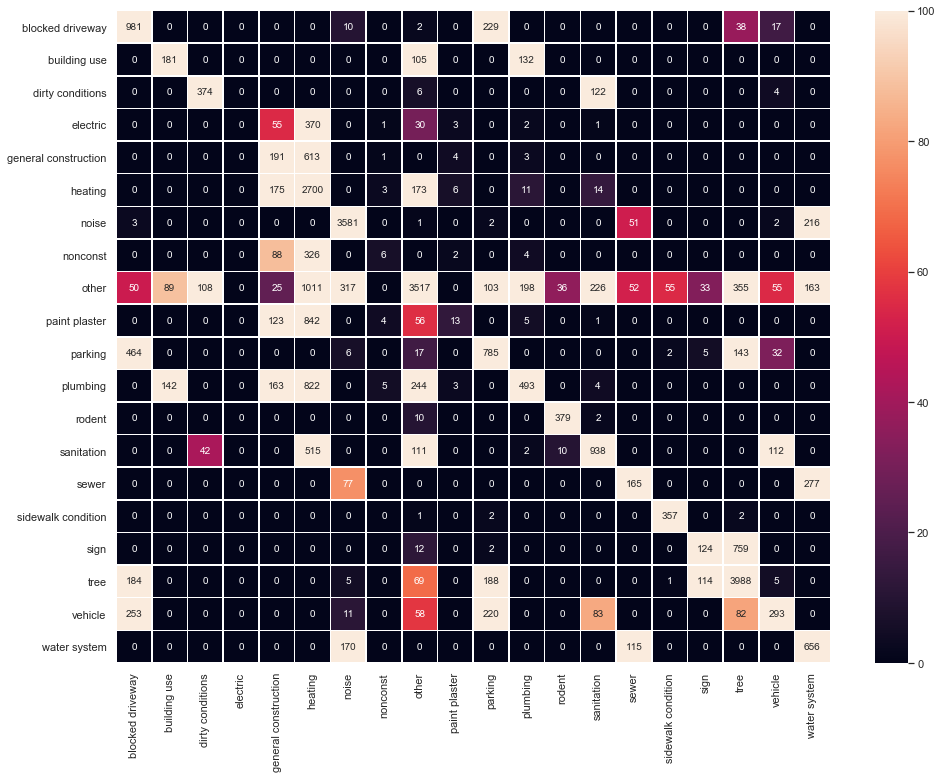

In [36]:
# Examine confusion matrix of last trained logistic regression model
# set color maximum to be low to highlight the misidentified cases
cm_lr = confusion_matrix(y_val, y_preds_lr)
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(cm_lr, annot=True, ax=ax, linewidths=0.5,
            fmt='d', xticklabels=le.classes_,
            yticklabels=le.classes_, vmax=100)

# fix graphical issue introduced in latest matplotlib
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

My guess that the model accuracies are low due to suboptimal condensing of the complaint types looks to be true. For example, "blocked driveway" gets confused with "parking" which seems reasonable. Model performance will likely go up with improved handling of the complaint types.

### Test set performance

The models should be retrained using all of the training data and then tested again on the final test set

In [37]:
# standardize features for logistic regression
scaler = preprocessing.StandardScaler()
X_scale = scaler.fit_transform(X)
X_scale_test = scaler.transform(X_test)
    
# create models
clf_lr = LogisticRegression(penalty='l2', solver='saga', random_state=RS, multi_class='auto', n_jobs=4)
clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=RS)
clf_xgb = xgb.XGBClassifier(n_jobs=4, objective='multi:softmax', num_class=y.unique().shape[0])
    
# fit each model
clf_lr.fit(X_scale, y) # requires the scaled training data
clf_rf.fit(X, y)
clf_xgb.fit(X, y)
    
# predict
y_preds_lr = clf_lr.predict(X_scale_test) # requires the scaled validation data
y_preds_rf = clf_rf.predict(X_test)
y_preds_xgb = clf_xgb.predict(X_test)
    
# accuracies
acc_lr = accuracy_score(y_test, y_preds_lr)
acc_rf = accuracy_score(y_test, y_preds_rf)
acc_xgb = accuracy_score(y_test, y_preds_xgb)

print(f'Logistic regression accuracy: {acc_lr}')
print(f'Random forest accuracy: {acc_rf}')
print(f'XGBoost accuracy: {acc_xgb}')

C:\Users\Alex\Miniconda3\envs\ds\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Logistic regression accuracy: 0.61675
Random forest accuracy: 0.620175
XGBoost accuracy: 0.641325


After including all of the data in the training set, the models did not change very much. For generality, this is good that the model has similar performance on unseen data. The accuracy of the models needs to be improved.

One area to look into would be the generalization of the complaint types. It might be possible to better group the complaints by first calculating the average word vector for each complaint type. A similarity matrix can be constructed indicating the strength of similarity between the complaint types. This could then be grouped by running a clustering algorithm using the similarity matrix as input.

Another are to look would be the transformation of the categorical variables into numerical values. There are other methods to do this which could be experimented with to determine if a particular transformation performs better.

In [38]:
# save models to disk
dump(clf_lr, 'models/logit.joblib')
dump(clf_rf, 'models/rf.joblib')
dump(clf_xgb, 'models/xgb.joblib')

['xgb.joblib']

## Further exploration

### Seasonality of Complaints

Additional exploration into the seasonality of the complaints could yield valuable insights for NYC. It's likely that certain types of complaints occur at certain times. It's also useful to track how complaint types change over time and in what area of the city.

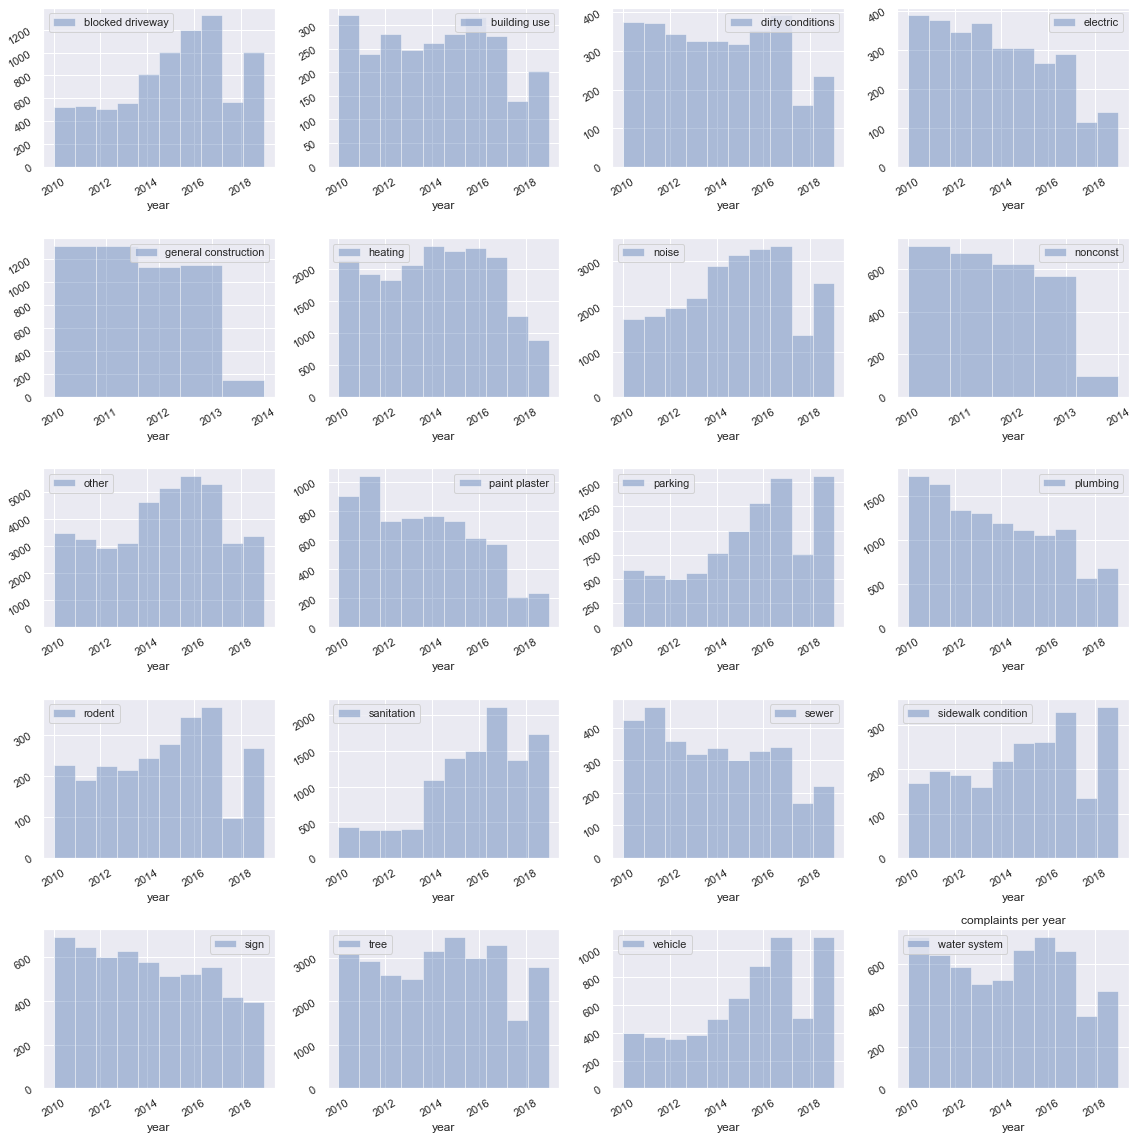

In [268]:
# complaints per year per class
figs, axes = plt.subplots(nrows=5, ncols=4, sharex=False, figsize=(16,16))
row, col = 0, 0
for i in range(20):
    if col > 3:
        col = 0
        row += 1
    data = df_samp[df_samp.complaint_encoded == i].year
    bins = data.unique().shape[0]
    sns.distplot(df_samp[df_samp.complaint_encoded == i].year, kde=False, ax=axes[row, col], bins=bins, label=le.classes_[i])
    axes[row, col].tick_params(labelrotation=30)
    axes[row, col].legend()
    col += 1
plt.title('complaints per year')
plt.tight_layout()

Some complaints appear to be slowly decreasing while others had certain years with high amounts of complaints. There are also a few complaints that look to be increasing. The latter would likely be where NYC would want to investigate further.

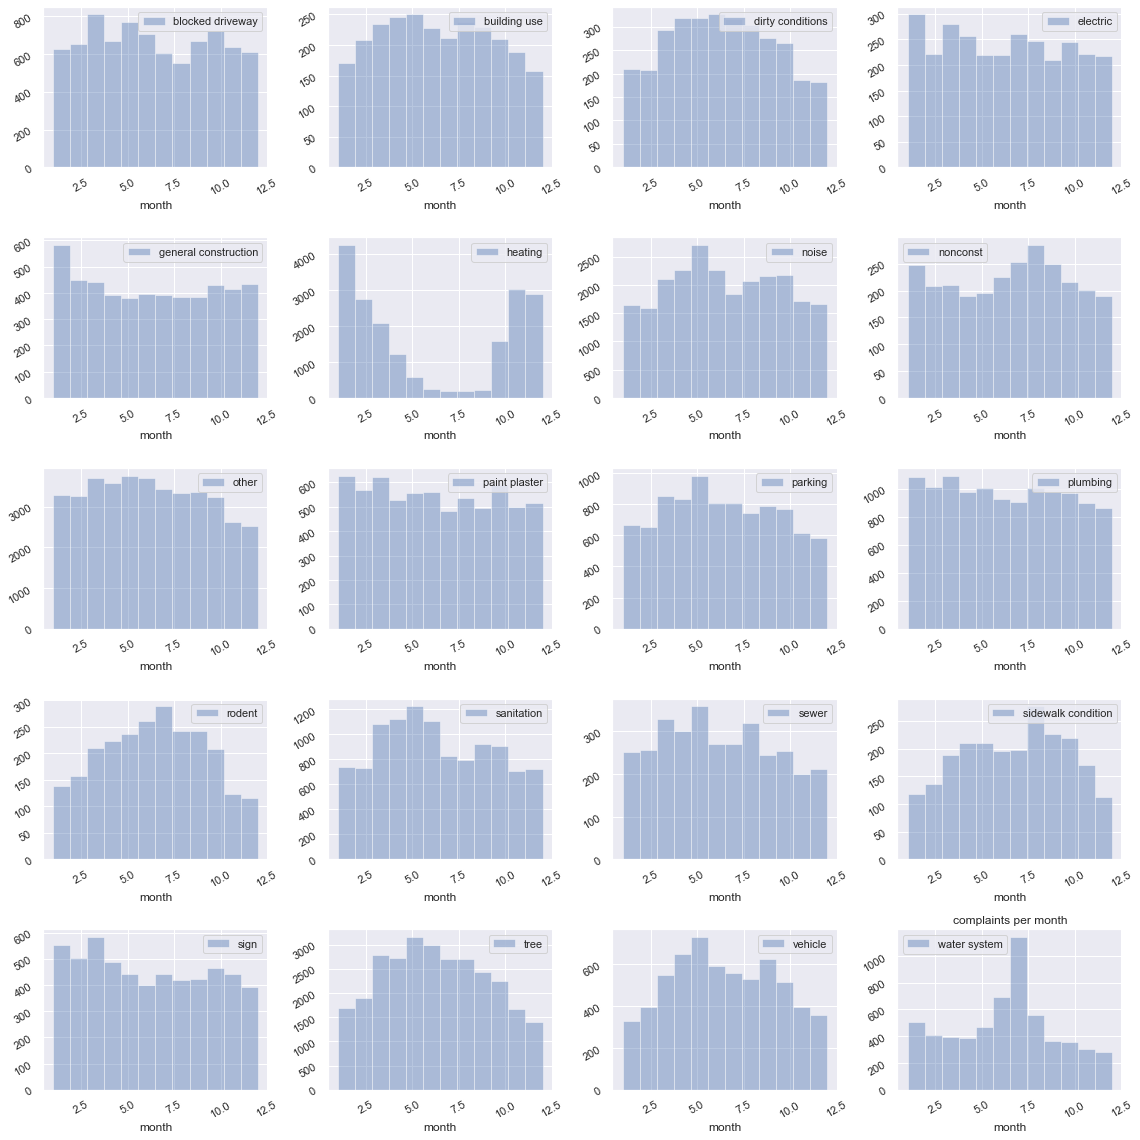

In [261]:
# complaints per month per class
figs, axes = plt.subplots(nrows=5, ncols=4, sharex=False, figsize=(16,16))
row, col = 0, 0
bins = df_samp.month.unique().shape[0]
for i in range(20):
    if col > 3:
        col = 0
        row += 1
    sns.distplot(df_samp[df_samp.complaint_encoded == i].month, kde=False, ax=axes[row, col], bins=bins, label=le.classes_[i])
    axes[row, col].tick_params(labelrotation=30)
    axes[row, col].legend()
    col += 1
plt.title('complaints per month')
plt.tight_layout()

Unsurprisingly, heating is typically complained about during cold weather months. It's interesting to see that the water system complaints spike sharply in the summer.

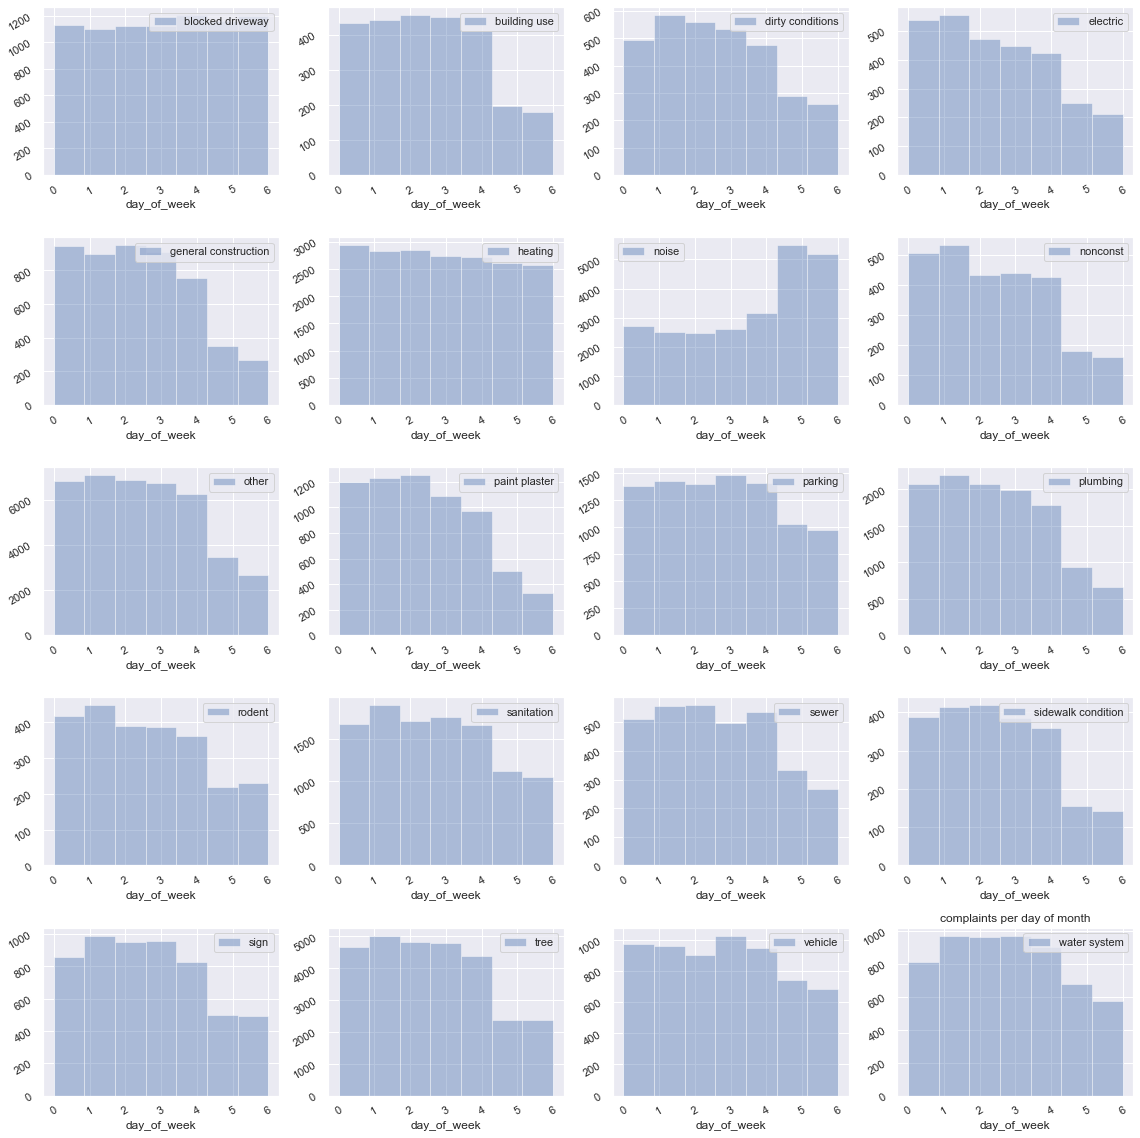

In [266]:
# complaints per day of week per class
# Monday is 0
figs, axes = plt.subplots(nrows=5, ncols=4, sharex=False, figsize=(16,16))
row, col = 0, 0
#bins = df_model.day.unique().shape[0]
bins = 7
for i in range(20):
    if col > 3:
        col = 0
        row += 1
    sns.distplot(df_samp[df_samp.complaint_encoded == i].day_of_week, kde=False, ax=axes[row, col], bins=bins, label=le.classes_[i])
    axes[row, col].tick_params(labelrotation=30)
    axes[row, col].legend()
    col += 1
plt.title('complaints per day of month')
plt.tight_layout()

Here it can be clearly seen that certain complaints are more likely on a week day rather than a weekend and vice versa.

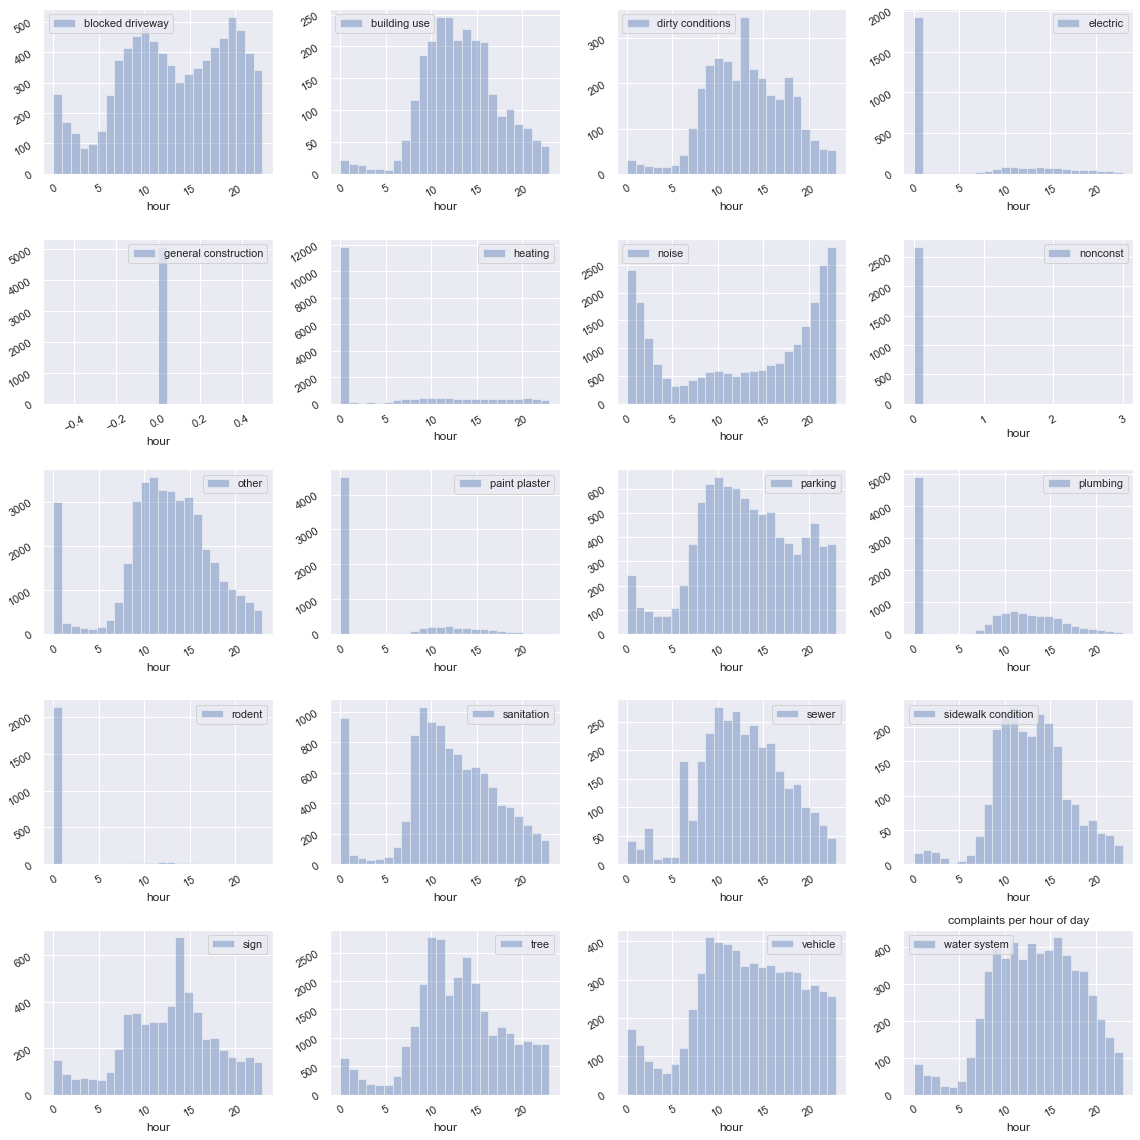

In [267]:
# complaints per hour per class
figs, axes = plt.subplots(nrows=5, ncols=4, sharex=False, figsize=(16,16))
row, col = 0, 0
bins = df_samp.hour.unique().shape[0]
for i in range(20):
    if col > 3:
        col = 0
        row += 1
    sns.distplot(df_samp[df_samp.complaint_encoded == i].hour, kde=False, ax=axes[row, col], bins=bins, label=le.classes_[i])
    axes[row, col].tick_params(labelrotation=30)
    axes[row, col].legend()
    col += 1
plt.title('complaints per hour of day')
plt.tight_layout()

There are, what appears to be, some data reporting issues that put a large amount of entries at 0. Could these come from NaNs? If the class consists of multiple original complaints, is there a particular complaint that gets associated with midnight?

### Complaints on a map

The x, y coordinates for each complaint is likely to be highly specific. It might be useful to round the positions to a certain point to generalize things a bit better. Originally the longitude and latitude values extended to 6 decimal places yielding 118,923 unique latitudes and longitudes.

In [39]:
df_samp.loc[:5, ['latitude', 'longitude']]

,latitude,longitude
0,40.581629,-73.953800
1,40.745545,-73.993154
2,40.801985,-73.961489
3,40.717699,-74.013990
4,40.843594,-73.941522
5,40.751910,-73.989941


In [40]:
df_samp.longitude.unique().shape

(118923,)

In [41]:
# round 3rd decimal to 0 or 5
df_samp.loc[:, 'latitude_rounded'] = df_samp.latitude.apply(lambda x: np.around(x*2, decimals=2)/2)
df_samp.loc[:, 'longitude_rounded'] = df_samp.longitude.apply(lambda x: np.around(x*2, decimals=2)/2)
print(df_samp.latitude_rounded.unique().shape)
print(df_samp.longitude_rounded.unique().shape)

(85,)
(110,)


Rounding to 4 decimals reduces the number of unique locations to 4,035. Using 3 reduces unique values to 416. Using 2 yields 43 unique. For the initial exploration, using 2 decimal places should keep the map from being too cluttered.

In [42]:
df_map = df_samp[(~df_samp.latitude.isna()) & (df_samp.year == 2017)].copy()
map_vc = df_map.groupby(['latitude_rounded', 'longitude_rounded', 'complaint_encoded']).size().reset_index().rename(columns={0:'count'})

In [43]:
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=11,
                        tiles="CartoDB dark_matter")
marker = folium.CircleMarker(location=[40.738, -73.98])
marker.add_to(folium_map)

In [44]:
for index, row in map_vc.iterrows():
    radius = row['count']
    if row['complaint_encoded'] == 6:
        color = "#E37222" # tangerine
    elif row['complaint_encoded'] == 10:
        color = '#0A8A9F' # teal
    else:
        continue
    folium.CircleMarker(location=(row['latitude_rounded'], row['longitude_rounded']),
                        radius=radius,
                        color=color,
                        fill=True).add_to(folium_map)

In [45]:
folium_map

The tangerine circles are noise complaints from 2017 while the teal circles are parking complaints from 2017. Noise complaints were quite common all along Manhattan while parking incidents seem to be in the southern end of Brooklyn.

This visualization can be extended to include time-lapse videos to better show the evolution of complaints. The process involves using `ffmpeg` to create videos from individual pictures (frames).